#Minianalysis: Last year used vs. X years into future

"""

filename: lastYearUsed_vs_x_Years_Into_Future.py

description: Take models run on the last year of GSS an article used and compare them vs that model on future 
             waves of GSS. Each difference in outcomes counts as one observation, i.e. many observations
             per article.

inputs:

outputs:

@author: Misha

"""

In [1]:
from __future__ import division

import matplotlib.pyplot as plt

import pandas as pd

#import cPickle as cp
import sys
sys.path.append('../')    
import GSSUtility as GU

import numpy as np
import statsmodels.formula.api as smf 
import random
from scipy.stats import pearsonr, ttest_ind, ttest_rel, nanmean, nanstd
import pickle
import time
from collections import Counter
from collections import defaultdict

import seaborn as sb
custom_style = {'axes.facecolor': 'white',
                'grid.color': '0.15',
                'grid.alpha':'0.5',
                'grid.linestyle':'-.'}
sb.set_style("darkgrid", rc=custom_style)

/home/misha/python/pandas-0.16.0-py2.7-linux-x86_64.egg/pandas/rpy/__init__.py:8: FutureWarning: The pandas.rpy module is deprecated and will be removed in a future version. We refer to external packages like rpy2, found here: http://rpy.sourceforge.net
  "like rpy2, found here: http://rpy.sourceforge.net", FutureWarning)


In [3]:
%rm ../GSSUtility.pyc # remove this file because otherwise it will be used instead of the updated .py file
reload(GU)

<module 'GSSUtility' from '../GSSUtility.py'>

In [10]:
if __name__ == "__main__":    

    pathToData = '../../Data/'
    dataCont = GU.dataContainer(pathToData)
    
    articlesToUse = GU.filterArticles(dataCont.articleClasses, GSSYearsUsed=True, GSSYearsPossible=True, centralIVs=False, \
                                     linearModels=True)            
    print 'len of articleClasses:', len(articlesToUse)
#     raw_input('...')
    
    # define the storage containers for outputs
    group1 = 'on_last_year_of_data'
    group2 = 'on_future_year'    
    output = defaultdict(dict)
    groups = [group1, group2]
    outcomes = ['propSig', 'paramSizesNormed', 'Rs', 'adjRs', 'pvalues', 'numTotal', \
                'propSig_CentralVars', 'paramSizesNormed_CentralVars', 'pvalues_CentralVars']
    
    for yr in range(43):
#         output[yr] = {}
        output[yr]['metadata'] = {}
        output[yr]['metadata']['last_GSS_year_used'] = []
        output[yr]['metadata']['future_GSS_year'] = []
        output[yr]['metadata']['articleID'] = []
        for group in groups:
            output[yr][group] = {}
            for outcome in outcomes:
                output[yr][group][outcome] = []
      
#    for article in random.sample(articlesToUse, 50):
    for article in articlesToUse:
    #for article in [a for a in articlesToUse if a.articleID == 6755]:
    
        print 'Processing article:', article.articleID
 
        '''             
        # define the outcomes I'm interseted in for the two groups. td = "temp data" 
        # and initialize them for both groups
        td = defaultdict(dict)
        for group in groups:             
            td[group]['numTotal'] = 0.0
    #        td[group]['coeffsSig'] = []
            td[group]['numSig'] = 0.0   # proportions of significant coeffs
    #        td[group]['paramSizes'] = []
            td[group]['paramSizesNormed'] = []
            td[group]['Rs'] = []
            td[group]['adjRs'] = []
            td[group]['pvalues'] = []
        '''
        RHS = article.IVs + article.controls
        
        for DV in article.DVs:
            
            # the 3 lines below is the model estimated on the last year of data used, and stays constant when i put it into
            # the output data structure. the loop below only goes over "future possible years"
            maxYearUsed = max(article.GSSYearsUsed)    

            resOnDataUsed = GU.runModel(dataCont, maxYearUsed, DV, RHS) # models run on max year of data used
            if not resOnDataUsed: continue

            # get column names of 'central variables'; this is tricky because some hve been dummy-fied                
            centralVars = []            
            for civ in article.centralIVs:
                if 'standardize(%s, ddof=1)' % (civ) in resOnDataUsed.params.index:
                    centralVars.append('standardize(%s, ddof=1)' % (civ))
                else: 
                    for col in resOnDataUsed.params.index:
                        if 'C(' + civ + ')' in col:
                            centralVars.append(col)
                    
            # The reasoning for the condition below is that authors make two types of arguments for "central" variables, 
            # (1) that the central variable is really important, p < 0.05, or (2) that the central variable is not important (p > 0.05). 
            # What we want to test by replacing the variable with a cognate are arguments of type (1). 
            # Arguments of type (2) are important and testable too, but if we test all of these together, we will obscure both effects.
            # So the condition below ensures that at least one of the central variables was found to be "important" in the original 
            # article.
            # This throws away 67 observations.
#             if np.all(resOnDataUsed.pvalues[centralVars] > 0.05): 
#                 print 'All "central" IVs are p > 0.05. Skipping.'
#                 continue

            # Now do future years
            futureYearsPossible = [yr for yr in article.GSSYearsPossible if yr > maxYearUsed]
            for futureYear in futureYearsPossible:
                resOnFutureYear = GU.runModel(dataCont, futureYear, DV, RHS) # models run on min year of future data
                if not resOnFutureYear: continue

                # Checks on which results to record                
                if len(resOnDataUsed.params) != len(resOnFutureYear.params):
                    print 'The number of variables in original model is different from the number in cognate model. Skipping.'                    
                    continue
                
                results = [resOnDataUsed, resOnFutureYear]
     
#                 print 'IVs:', article.IVs
#                 print 'centralVars:', centralVars
                
                for i in range(2):                 
                    output[futureYear - maxYearUsed][groups[i]]['Rs'].append(results[i].rsquared) 
                    output[futureYear - maxYearUsed][groups[i]]['adjRs'].append(results[i].rsquared_adj) 
                    output[futureYear - maxYearUsed][groups[i]]['propSig'].append(float(len([p for p in results[i].pvalues[1:] if p < 0.05]))/len(results[i].params[1:])) 
                    output[futureYear - maxYearUsed][groups[i]]['paramSizesNormed'].append(np.mean(results[i].params[1:].abs())) 
                    '''
                    if np.isnan(np.mean( td[group]['paramSizesNormed'])).any():
                        print results[i].summary()
                        raise
                    '''
                    output[futureYear - maxYearUsed][groups[i]]['pvalues'].append(np.mean( results[i].pvalues[1:]))
                    output[futureYear - maxYearUsed][groups[i]]['numTotal'].append( 1 ) #divide by len of R^2 array to get a mean of variables estimated PER model                           

                    if len(centralVars)>0:
                        output[futureYear - maxYearUsed][groups[i]]['pvalues_CentralVars'].append(np.mean(results[i].pvalues[centralVars]))               
                        output[futureYear - maxYearUsed][groups[i]]['propSig_CentralVars'].append(float(len([p for p in results[i].pvalues[centralVars] if p < 0.05])) \
                                                                /len(results[i].params[centralVars])) 
                        output[futureYear - maxYearUsed][groups[i]]['paramSizesNormed_CentralVars'].append(np.mean(results[i].params[centralVars].abs()))                
                    
                    else:
                        output[futureYear - maxYearUsed][groups[i]]['pvalues_CentralVars'].append(np.nan)               
                        output[futureYear - maxYearUsed][groups[i]]['propSig_CentralVars'].append(np.nan)                                                        
                        output[futureYear - maxYearUsed][groups[i]]['paramSizesNormed_CentralVars'].append(np.nan)                

                
                # Now fill out metadata. It's not in the loop above because it's the same for both groups
                output[futureYear - maxYearUsed]['metadata']['last_GSS_year_used'].append(maxYearUsed)
                output[futureYear - maxYearUsed]['metadata']['future_GSS_year'].append(futureYear)
                output[futureYear - maxYearUsed]['metadata']['articleID'].append(article.articleID)                 

#     print 'TTests'

#     for year in range(43):
#         for outcome in outcomes:
#             print year            
#             print 'Means of group1 and group2:', np.mean(output[year][group1][outcome]), np.mean(output[year][group2][outcome]), \
#                     'Paired T-test of ' + outcome, ttest_rel(output[year][group1][outcome], output[year][group2][outcome])

Loading DataFrame df. This may take a few minutes.
len of articleClasses: 514


TypeError: exceptions must be old-style classes or derived from BaseException, not NoneType

In [3]:
pickle.dump(output, open('output.pickle', 'w'))

NameError: name 'output' is not defined

In [2]:
output = pickle.load(open('output.pickle'))

In [3]:
# info on the articles used
all_articles = []
for yr in range(43):
    all_articles.extend(output[yr]['metadata']['articleID'])
print 'Num of unique articles used:', len(set(all_articles))

Num of unique articles used: 220


In [4]:
output[0]['metadata']['articleID']

[]

#Plot outcomes x years into future

Notes
--
An important **question** is why the actual outcomes show time-trends (see below). I don't know the answer, but I'm not very concerned because the x-axis here is NOT time. It's the difference between last year of GSS used and a future year.

A clue is that the sample size that goes into computing each mean (blue dot) decreases with the time-difference (see plot below). But **I don't know why this would matter.**



First, plot the actual outcomes (not *differences*)
--

NameError: name 'group1' is not defined

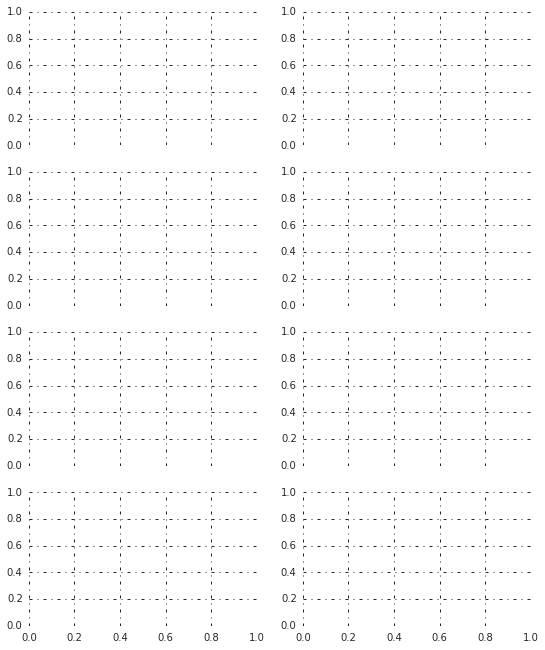

In [6]:
%matplotlib inline
# group1 = 'on_last_year_of_data'
# group2 = 'on_future_year'    

YEARS = range(43)
results={}

outcomeMap = {'propSig':"Proportion of Stat. Sign. Coeff's", 
              'paramSizesNormed':"Standard. Size of Coeff's",
              'Rs':'R_squared', 
              'adjRs':'Adjusted R_squared',
              'pvalues':"Average P-Value of Coeff's",
              'propSig_CentralVars':"Cent. Var's: Proportion of Stat. Sign. Coeff's",
              'paramSizesNormed_CentralVars':"Cent. Var's: Standard. Size of Coeff's", 
              'pvalues_CentralVars':"Cent. Var's: Average P-Value of Coeff's"}


f, axarr = plt.subplots(4, 2, sharex=True)
axarr = axarr.flatten()
f.set_size_inches(9,11)

# just re-arranging the list of outcomes so they get plotted in the order i want
outcomes_ordered = ['propSig', 'propSig_CentralVars',
              'paramSizesNormed', 'paramSizesNormed_CentralVars', 
              'pvalues','pvalues_CentralVars',
               'Rs', 'adjRs']

for i, outcome in enumerate(outcomes_ordered):
    
    onGp1 = [np.array(output[year][group1][outcome]) for year in YEARS]  
    onGp2 = [np.array(output[year][group2][outcome]) for year in YEARS]  

#     yerr = [2*np.std(x) for x in yearlyDiffs]
    meansGp1 = [np.mean(x) for x in onGp1]
    meansGp2 = [np.mean(x) for x in onGp2]
        
    xGp1, yGp1, xGp2, yGp2 = [], [], [], [] 
    for yr in YEARS:
         xGp1.extend([yr]*len(onGp1[yr]))
         yGp1.extend(onGp1[yr])
         xGp2.extend([yr]*len(onGp2[yr]))
         yGp2.extend(onGp2[yr])

    axarr[i].plot(YEARS, meansGp1, '.', color='red', alpha=0.7)
    axarr[i].plot(YEARS, meansGp2, '.', color='blue', alpha=0.7)
    axarr[i].set_title(outcomeMap[outcome], fontsize=14)
    
    # add regression line
    formula = outcome+'~years'
#     result = smf.rlm(formula, data=pd.DataFrame({'years':x, outcome:y}).dropna(axis=0), missing='drop').fit()
    resultGp1 = smf.ols(formula, data=pd.DataFrame({'years':xGp1, outcome:yGp1}).dropna(axis=0), missing='drop').fit()
    resultGp2 = smf.ols(formula, data=pd.DataFrame({'years':xGp2, outcome:yGp2}).dropna(axis=0), missing='drop').fit()
    axarr[i].plot(YEARS, np.array(YEARS)*resultGp1.params[1] + resultGp1.params[0], 'r--', label='OnLastYearUsed')
    axarr[i].plot(YEARS, np.array(YEARS)*resultGp2.params[1] + resultGp2.params[0], 'b--', label='OnFutureYear')

    # add the slope and its p-value
    axarr[i].annotate('slope=' + str(np.around(resultGp1.params[1],4))+ ', p=' + str(np.around(resultGp1.pvalues[1],3)), 
                      xy=(0, 0), xycoords='axes fraction', fontsize=12, ha='left', va='bottom', 
                      xytext=(5,5), textcoords='offset points')
    
    # print the intercept and its p-value for my inspection, not on the figure
#     print 'intercept:'+str(result.params[0])+', '+str(result.pvalues[0])

# add title and common x-label
f.text(0.5, 0.05, 'Years after publication', ha='center',  va='bottom',fontsize=14)
f.text(0.5, 1-0.05, 'Outcomes x-Years Into Future', ha='center', fontsize=20)
f.text(0.5, 1-0.075, 'Red: on last year used, Blue: on future year', ha='center', fontsize=18, style='italic', color='red')

# savefig('../../Images/2014-10-06-TWO-CURVES-outcomes_last_year_vs_x_years_into_future_all_8.png')

NOTE: 
--
**the x-axis in the graphs above is difficult is tricky because it doesn't show chronological time**

And I've already looked at trends in outcomes over time and didn't find any trends!

Plot number of points at each time period
--

In [ ]:
SIZES = [len(x) for x in onGp1]
plot(YEARS, SIZES)
title('Number of models at each time-difference (for graphs above)')
xlabel('Years after publication')


Average 'last year used' and 'future_gss_year' vs time-gap
--

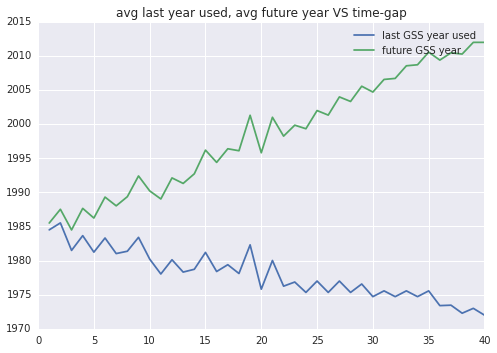

In [43]:
MAX_YEAR_USED = [np.mean(output[year]['metadata']['last_GSS_year_used']) for year in YEARS]
FUTURE_GSS_YEAR = [np.mean(output[year]['metadata']['future_GSS_year']) for year in YEARS]
plot(YEARS, MAX_YEAR_USED, label='last GSS year used')
plot(YEARS, FUTURE_GSS_YEAR, label='future GSS year')
title('avg last year used, avg future year VS time-gap')
legend()
# savefig('../../Images/2014-10-06-avg last year used vs avg future year vs time gap.png')

#NEW CODE: Plot the *differences* 


intercept:-0.0100573682959, 0.0443069332643
intercept:-0.00289078553264, 0.664531998676
intercept:-0.00727073634209, 2.0044589628e-07
intercept:-0.00714870073291, 1.41465606066e-05
intercept:0.00470678468335, 0.147457447169
intercept:-0.00123252485036, 0.779475289538
intercept:-0.00679912984202, 4.45976708167e-21
intercept:-0.00654535839574, 1.70164374518e-19


/home/misha/python/numpy-1.8.1-py2.7-linux-x86_64.egg/numpy/core/_methods.py:55: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


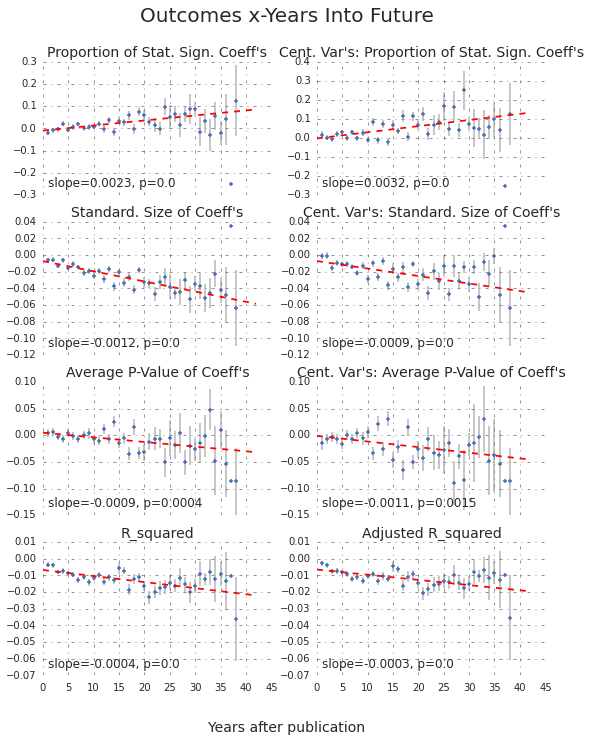

In [7]:
%matplotlib inline
group1 = 'on_last_year_of_data'
group2 = 'on_future_year'    
groups = [group1, group2]
outcomes = ['propSig', 'paramSizesNormed', 'Rs', 'adjRs', 'pvalues', 'numTotal', \
            'propSig_CentralVars', 'paramSizesNormed_CentralVars', 'pvalues_CentralVars']
    
# group1 = 'on_last_year_of_data'
# group2 = 'on_future_year'    

#ax.errorbar(x, y, yerr=yerr, fmt='o')

#fig, axs = plt.subplots(nrows=len(outcomes), ncols=1, sharex=True)

#fig = pl.figure(figsize=(3,8))
#fig = plt.figure(1, figsize=(8,25))

YEARS = range(43)
results={}

outcomeMap = {'propSig':"Proportion of Stat. Sign. Coeff's", 
              'paramSizesNormed':"Standard. Size of Coeff's",
              'Rs':'R_squared', 
              'adjRs':'Adjusted R_squared',
              'pvalues':"Average P-Value of Coeff's",
              'propSig_CentralVars':"Cent. Var's: Proportion of Stat. Sign. Coeff's",
              'paramSizesNormed_CentralVars':"Cent. Var's: Standard. Size of Coeff's", 
              'pvalues_CentralVars':"Cent. Var's: Average P-Value of Coeff's"}


f, axarr = plt.subplots(4, 2, sharex=True)
axarr = axarr.flatten()
f.set_size_inches(9,11)

# just re-arranging the list of outcomes so they get plotted in the order i want
outcomes_ordered = ['propSig', 'propSig_CentralVars',
              'paramSizesNormed', 'paramSizesNormed_CentralVars', 
              'pvalues','pvalues_CentralVars',
               'Rs', 'adjRs']

for i, outcome in enumerate(outcomes_ordered):
    
    yearlyDiffs = [np.array(output[year][group2][outcome]) - np.array(output[year][group1][outcome]) for year in YEARS]  
    yerr = [nanstd(x)/np.sqrt(len(x)) for x in yearlyDiffs]
    means = [nanmean(x) for x in yearlyDiffs]
    
    x, y = [], []  
    for yr in YEARS:
         x.extend([yr]*len(yearlyDiffs[yr]))
         y.extend(yearlyDiffs[yr])
#          y_means.append(np.mean(output[yr][group2][outcome]))

    #         for diffy in yearlyDiffs[j]:
#             x.append(j)
#             y.append(diffy)    
            
    # note, i'm plotting means because plotting each point makes the plot crowded,
    # but i'm calculating the regression line on the un-aggregated data!    
#     plot(years, means, '.', alpha=0.8)  

    # i am not plotting the line below because it changes the y-axis and it's hard to see any trend!!!
#     axarr[i].plot(x, y, '.', alpha=0.1)
#            errorbar(years, means, yerr=yerr)

#     ylabel('Change in ' + outcomeMap[outcome])

    axarr[i].plot(YEARS, means, '.')
    axarr[i].errorbar(YEARS, means, yerr=yerr, linestyle='None', alpha=0.5, color='gray')
    
    axarr[i].set_title(outcomeMap[outcome], fontsize=14)
    
    # add regression line
    formula = outcome+'~years'
#     result = smf.rlm(formula, data=pd.DataFrame({'years':x, outcome:y}).dropna(axis=0), missing='drop').fit()
    result = smf.ols(formula, data=pd.DataFrame({'years':x, outcome:y}).dropna(axis=0), missing='drop').fit()
    axarr[i].plot(YEARS, np.array(YEARS)*result.params[1] + result.params[0], 'r--')

    # add the slope and its p-value
    axarr[i].annotate('slope=' + str(np.around(result.params[1],4))+ ', p=' + str(np.around(result.pvalues[1],4)), 
                      xy=(0, 0), xycoords='axes fraction', fontsize=12, ha='left', va='bottom', 
                      xytext=(5,5), textcoords='offset points')
    
    # print the intercept and its p-value for my inspection, not on the figure
    print 'intercept:'+str(result.params[0])+', '+str(result.pvalues[0])
    axarr[i].grid(alpha=0.5)
    
# add title and common x-label
f.text(0.5, 0.05, 'Years after publication', ha='center',  va='bottom',fontsize=14)
f.text(0.5, 1-0.05, 'Outcomes x-Years Into Future', ha='center', fontsize=20)

# savefig('../../Images/9-29-2014--outcomes_last_year_vs_x_years_into_future_all_8.png')

OLD CODE: Second, plot the *differences* in outcomes between last_year_used and future_year
--

TypeError: There is no line property "yerr"

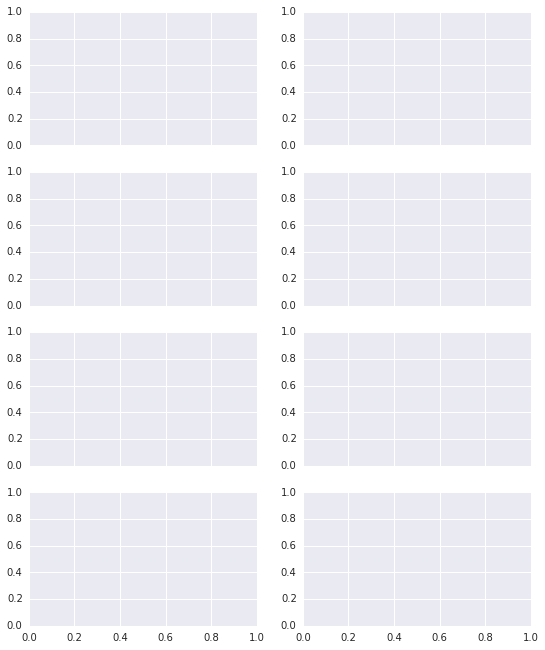

In [6]:
# group1 = 'on_last_year_of_data'
# group2 = 'on_future_year'    

#ax.errorbar(x, y, yerr=yerr, fmt='o')

#fig, axs = plt.subplots(nrows=len(outcomes), ncols=1, sharex=True)

#fig = pl.figure(figsize=(3,8))
#fig = plt.figure(1, figsize=(8,25))
YEARS = range(43)
results={}

outcomeMap = {'propSig':"Proportion of Stat. Sign. Coeff's", 
              'paramSizesNormed':"Standard. Size of Coeff's",
              'Rs':'R_squared', 
              'adjRs':'Adjusted R_squared',
              'pvalues':"Average P-Value of Coeff's",
              'propSig_CentralVars':"Cent. Var's: Proportion of Stat. Sign. Coeff's",
              'paramSizesNormed_CentralVars':"Cent. Var's: Standard. Size of Coeff's", 
              'pvalues_CentralVars':"Cent. Var's: Average P-Value of Coeff's"}


f, axarr = plt.subplots(4, 2, sharex=True)
axarr = axarr.flatten()
f.set_size_inches(9,11)

# just re-arranging the list of outcomes so they get plotted in the order i want
outcomes_ordered = ['propSig', 'propSig_CentralVars',
              'paramSizesNormed', 'paramSizesNormed_CentralVars', 
              'pvalues','pvalues_CentralVars',
               'Rs', 'adjRs']

for i, outcome in enumerate(outcomes_ordered):
    
    yearlyDiffs = [np.array(output[year][group2][outcome]) - np.array(output[year][group1][outcome]) for year in YEARS]  
    yerr = [2*np.std(x)/np.sqrt(len(x)) for x in yearlyDiffs]
    means = [np.mean(x) for x in yearlyDiffs]
    
    x, y = [], []  
    for yr in YEARS:
         x.extend([yr]*len(yearlyDiffs[yr]))
         y.extend(yearlyDiffs[yr])
#          y_means.append(np.mean(output[yr][group2][outcome]))

    #         for diffy in yearlyDiffs[j]:
#             x.append(j)
#             y.append(diffy)    
            
    # note, i'm plotting means because plotting each point makes the plot crowded,
    # but i'm calculating the regression line on the un-aggregated data!    
#     plot(years, means, '.', alpha=0.8)  

    # i am not plotting the line below because it changes the y-axis and it's hard to see any trend!!!
#     axarr[i].plot(x, y, '.', alpha=0.1)
#            errorbar(years, means, yerr=yerr)

#     ylabel('Change in ' + outcomeMap[outcome])

    axarr[i].plot(YEARS, means, '.')
    axarr[i].set_title(outcomeMap[outcome], fontsize=14)
    
    # add regression line
    formula = outcome+'~years'
#     result = smf.rlm(formula, data=pd.DataFrame({'years':x, outcome:y}).dropna(axis=0), missing='drop').fit()
    result = smf.ols(formula, data=pd.DataFrame({'years':x, outcome:y}).dropna(axis=0), missing='drop').fit()
    axarr[i].plot(YEARS, np.array(YEARS)*result.params[1] + result.params[0], 'r--')

    # add the slope and its p-value
    axarr[i].annotate('slope=' + str(np.around(result.params[1],4))+ ', p=' + str(np.around(result.pvalues[1],3)), 
                      xy=(0, 0), xycoords='axes fraction', fontsize=12, ha='left', va='bottom', 
                      xytext=(5,5), textcoords='offset points')
    
    # print the intercept and its p-value for my inspection, not on the figure
    print 'intercept:'+str(result.params[0])+', '+str(result.pvalues[0])

# add title and common x-label
f.text(0.5, 0.05, 'Years after publication', ha='center',  va='bottom',fontsize=14)
f.text(0.5, 1-0.05, 'Outcomes x-Years Into Future', ha='center', fontsize=20)

# savefig('../../Images/9-29-2014--outcomes_last_year_vs_x_years_into_future_all_8.png')

Robustness check
--

Description: 
Use *clustered standard errors* to do significance tests.
Note: I am not using the 'df_correction' flag in get_robustcov_results() because that's apparently something HLM does, not canonical clustered errors:
"This method of correcting the standard errors to account for the intraclass correlation is a "weaker" form of correction than using a multilevel model, which not only accounts for the intraclass correlation, but also corrects the denominator degrees of freedom for the number of clusters."
source: http://www.ats.ucla.edu/stat/stata/library/cpsu.htm

Outcome
--
All outcomes are still p < 0.05 (!!!) except the time-trends in p-values, which are not p > 0.05. 


intercept:-0.0445029019115, 0.0173984062965
intercept:-0.0824149502679, 0.0112924462386
intercept:-0.00361499988026, 0.376681012537
intercept:-0.00593348533164, 0.166692784891
intercept:0.021833538167, 0.0879553921973
intercept:0.0405042247926, 0.0233637103704
intercept:0.000468872406361, 0.865988888285
intercept:-0.000329075559239, 0.903003714022


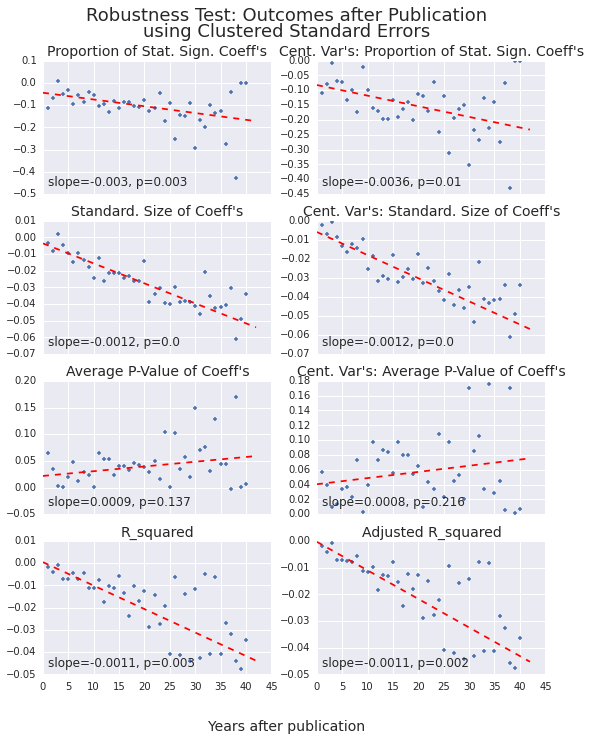

In [60]:
# group1 = 'on_last_year_of_data'
# group2 = 'on_future_year'    

#ax.errorbar(x, y, yerr=yerr, fmt='o')

#fig, axs = plt.subplots(nrows=len(outcomes), ncols=1, sharex=True)

#fig = pl.figure(figsize=(3,8))
#fig = plt.figure(1, figsize=(8,25))
YEARS = range(43)
results={}

outcomeMap = {'propSig':"Proportion of Stat. Sign. Coeff's", 
              'paramSizesNormed':"Standard. Size of Coeff's",
              'Rs':'R_squared', 
              'adjRs':'Adjusted R_squared',
              'pvalues':"Average P-Value of Coeff's",
              'propSig_CentralVars':"Cent. Var's: Proportion of Stat. Sign. Coeff's",
              'paramSizesNormed_CentralVars':"Cent. Var's: Standard. Size of Coeff's", 
              'pvalues_CentralVars':"Cent. Var's: Average P-Value of Coeff's"}


f, axarr = plt.subplots(4, 2, sharex=True)
axarr = axarr.flatten()
f.set_size_inches(9,11)

# just re-arranging the list of outcomes so they get plotted in the order i want
outcomes_ordered = ['propSig', 'propSig_CentralVars',
              'paramSizesNormed', 'paramSizesNormed_CentralVars', 
              'pvalues','pvalues_CentralVars',
               'Rs', 'adjRs']

for i, outcome in enumerate(outcomes_ordered):
    
    x, y, yerr, means = [], [], [], []  
    article_indices = []
    
    for yr in YEARS:
        yearlyDiffs = np.array(output[yr][group2][outcome]) - \
                                np.array(output[yr][group1][outcome])  
        x.extend([yr]*len(yearlyDiffs))
        y.extend(yearlyDiffs)
        means.append(np.mean(yearlyDiffs))
        yerr.append(2*np.std(yearlyDiffs))

        article_indices.extend(output[yr]['metadata']['articleID'])

        #          y_means.append(np.mean(output[yr][group2][outcome]))

    #         for diffy in yearlyDiffs[j]:
#             x.append(j)
#             y.append(diffy)    
            
    # note, i'm plotting means because plotting each point makes the plot crowded,
    # but i'm calculating the regression line on the un-aggregated data!    
#     plot(years, means, '.', alpha=0.8)  

    # i am not plotting the line below because it changes the y-axis and it's hard to see any trend!!!
#     axarr[i].plot(x, y, '.', alpha=0.1)
#            errorbar(years, means, yerr=yerr)

#     ylabel('Change in ' + outcomeMap[outcome])

    axarr[i].plot(YEARS, means, '.')
    axarr[i].set_title(outcomeMap[outcome], fontsize=14)
    
    # add regression line
    formula = outcome+'~years'
#     result = smf.rlm(formula, data=pd.DataFrame({'years':x, outcome:y}).dropna(axis=0), missing='drop').fit()
    result = smf.ols(formula, data=pd.DataFrame({'years':x, outcome:y}).dropna(axis=0), \
                     missing='drop').fit(cov_type='cluster', \
                                         cov_kwds=dict(groups=article_indices))
    
    axarr[i].plot(YEARS, np.array(YEARS)*result.params[1] + result.params[0], 'r--')

# section below no longer necessary because i'm passing keyword args for 'cluster' into the model.fit() method above
#     # GET CLUSTERED ERRORS
#     robust_results = result.get_robustcov_results(cov_type='cluster', 
#                                                   groups=article_indices, 
#                                                   df_correction=True) # try True
    
    

    # add the slope and its p-value
    axarr[i].annotate('slope=' + str(np.around(result.params[1],4))+ \
                      ', p=' + str(np.around(result.pvalues[1],3)), \
                      xy=(0, 0), xycoords='axes fraction', fontsize=12, ha='left', va='bottom', \
                      xytext=(5,5), textcoords='offset points')
    
    # print the intercept and its p-value for my inspection, not on the figure
    print 'intercept:'+str(result.params[0])+', '+str(result.pvalues[0])    

# add title and common x-label
f.text(0.5, 0.05, 'Years after publication', ha='center',  va='bottom',fontsize=14)
f.text(0.5, 1-0.05, 'Robustness Test: Outcomes after Publication', ha='center', fontsize=18)
f.text(0.5, 1-0.07, 'using Clustered Standard Errors', ha='center', fontsize=18)

savefig('../../Images/10-23-2014--robustness_test--outcomes_after_publication_with_clustered_errors.png')